In [1]:
import numpy as np
import tensorflow as tf

In [2]:
import functools
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data


def doublewrap(function):
    """
    A decorator decorator, allowing to use the decorator to be used without
    parentheses if not arguments are provided. All arguments must be optional.
    """
    @functools.wraps(function)
    def decorator(*args, **kwargs):
        if len(args) == 1 and len(kwargs) == 0 and callable(args[0]):
            return function(args[0])
        else:
            return lambda wrapee: function(wrapee, *args, **kwargs)
    return decorator


@doublewrap
def define_scope(function, scope=None, *args, **kwargs):
    """
    A decorator for functions that define TensorFlow operations. The wrapped
    function will only be executed once. Subsequent calls to it will directly
    return the result so that operations are added to the graph only once.
    The operations added by the function live within a tf.variable_scope(). If
    this decorator is used with arguments, they will be forwarded to the
    variable scope. The scope name defaults to the name of the wrapped
    function.
    """
    attribute = '_cache_' + function.__name__
    name = scope or function.__name__
    @property
    @functools.wraps(function)
    def decorator(self):
        if not hasattr(self, attribute):
            with tf.variable_scope(name, *args, **kwargs):
                setattr(self, attribute, function(self))
        return getattr(self, attribute)
    return decorator

In [ ]:
class TestModel(object):
    def __init__(self):
        self.input = tf.placeholder()
        self.prediction

    @define_scope
    def prediction(self):
    

In [3]:
import pandas as pd

In [5]:
df = pd.read_csv('data/train_1.csv')

# First working with generated data..



In [20]:
import random
import matplotlib.pyplot as plt
%matplotlib notebook

<IPython.core.display.Javascript object>


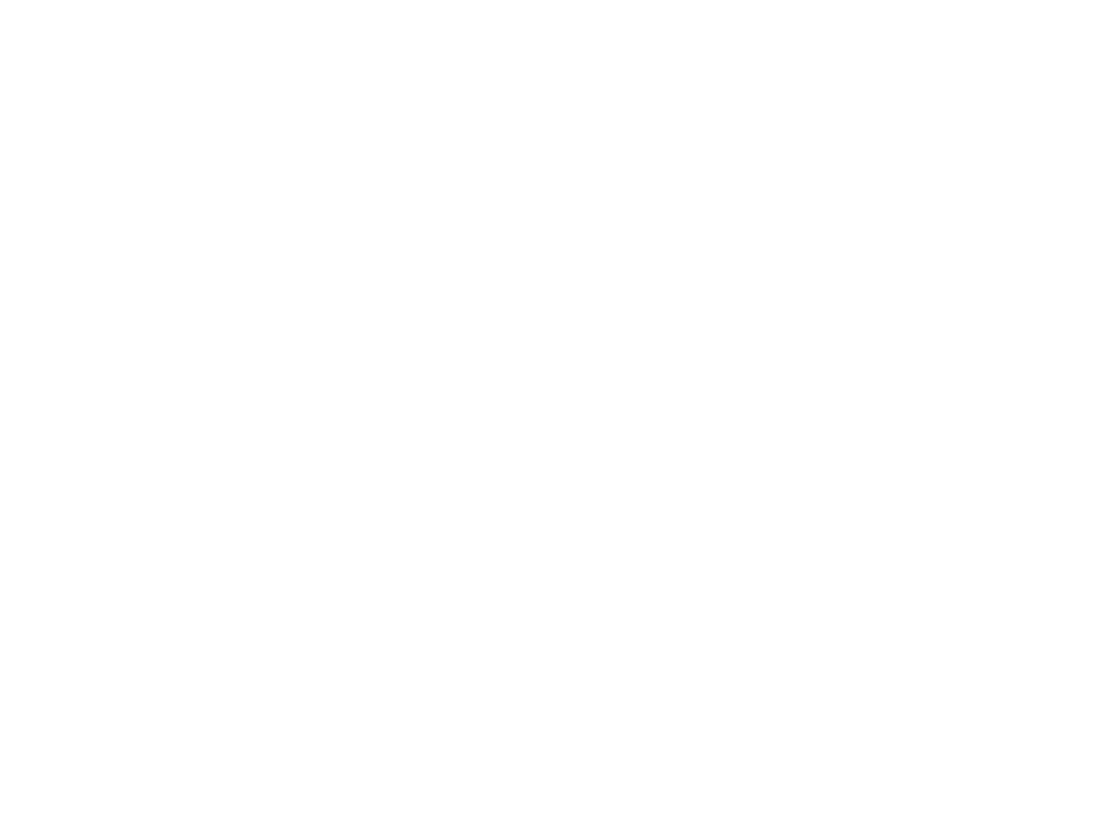

AttributeError: 'numpy.ndarray' object has no attribute 'plot'

In [120]:
# code from https://mapr.com/blog/deep-learning-tensorflow/
random.seed(1)

rng = pd.date_range(start='2000', periods=209, freq='M')
ts = pd.Series(np.random.uniform(-10, 10, size=len(rng)), rng).cumsum()
plt.figure()

ts.plot(c='b', title='Random time series')

plt.show()
ts.head(10)

In [122]:
#ts = np.arange(209)  # <-- let's first test with just an increasing serie.. easier at the beginning
ts = np.sin(np.arange(209)) # testons avec un sinus

TS = np.array(ts)
num_periods = 20
f_horizon = 1 # forcasting horizon, one period into future

TS.shape
x_data = TS[:(len(TS)-(len(TS) % num_periods))]  # just to keep a number of elements dividable by num_periods

# spliting by num periods

x_batches = x_data.reshape(-1, num_periods, 1)

y_data = TS[f_horizon:(len(TS)-(len(TS)%num_periods))+f_horizon]
# just to associate correct y label

# Warning.. the following line works... because we have a rest in euclidean division.. indeed we have 209 values
# TODO: maybee think of a better way to do this kind of split in python/numpy..
# but for the exercice that's ok

# 209 observation au total.. et la on se fait 10 batches de 20 observations
y_batches = y_data.reshape(-1, num_periods, 1)
x_batches

array([[[ 0.        ],
        [ 0.84147098],
        [ 0.90929743],
        [ 0.14112001],
        [-0.7568025 ],
        [-0.95892427],
        [-0.2794155 ],
        [ 0.6569866 ],
        [ 0.98935825],
        [ 0.41211849],
        [-0.54402111],
        [-0.99999021],
        [-0.53657292],
        [ 0.42016704],
        [ 0.99060736],
        [ 0.65028784],
        [-0.28790332],
        [-0.96139749],
        [-0.75098725],
        [ 0.14987721]],

       [[ 0.91294525],
        [ 0.83665564],
        [-0.00885131],
        [-0.8462204 ],
        [-0.90557836],
        [-0.13235175],
        [ 0.76255845],
        [ 0.95637593],
        [ 0.27090579],
        [-0.66363388],
        [-0.98803162],
        [-0.40403765],
        [ 0.55142668],
        [ 0.99991186],
        [ 0.52908269],
        [-0.42818267],
        [-0.99177885],
        [-0.64353813],
        [ 0.29636858],
        [ 0.96379539]],

       [[ 0.74511316],
        [-0.15862267],
        [-0.91652155],
       

In [123]:
def test_data(series, forecast, num_periods):
    test_x_setup = series[-(num_periods+forecast):]
    testX = test_x_setup[:num_periods].reshape(-1, num_periods, 1)
    testY = TS[-(num_periods):].reshape(-1, num_periods, 1)
    return testX, testY

X_test, Y_test = test_data(TS, f_horizon, num_periods)
print(X_test.shape)
print(X_test)

# so we are using the last part of the data as our test..
# seems legits.. whereas.. there is a short overlap between test and training..
# but again ok for the exercice
print(Y_test)

(1, 20, 1)
[[[-0.47552367]
  [ 0.48331795]
  [ 0.99779928]
  [ 0.59490855]
  [-0.35493836]
  [-0.97845657]
  [-0.70238633]
  [ 0.21945467]
  [ 0.93953006]
  [ 0.79580584]
  [-0.07957859]
  [-0.88179884]
  [-0.8732973 ]
  [-0.06189025]
  [ 0.80641841]
  [ 0.9333097 ]
  [ 0.20212036]
  [-0.71489751]
  [-0.9746419 ]
  [-0.33830503]]]
[[[ 0.48331795]
  [ 0.99779928]
  [ 0.59490855]
  [-0.35493836]
  [-0.97845657]
  [-0.70238633]
  [ 0.21945467]
  [ 0.93953006]
  [ 0.79580584]
  [-0.07957859]
  [-0.88179884]
  [-0.8732973 ]
  [-0.06189025]
  [ 0.80641841]
  [ 0.9333097 ]
  [ 0.20212036]
  [-0.71489751]
  [-0.9746419 ]
  [-0.33830503]
  [ 0.60906793]]]


In [124]:
# The model

tf.reset_default_graph()

n_inputs = 1  # number of vector submitted
hidden = 1000 # number of neurons we will recursively work through
output = 1  # number of output vectors

X = tf.placeholder(tf.float32, [None, num_periods, n_inputs])
y = tf.placeholder(tf.float32, [None, num_periods, output])

basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=hidden, activation=tf.nn.relu)
rnn_output, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32)

learning_rate = 0.003   # small learning rate.. so no overshoot the minimum

stacked_rnn_output = tf.reshape(rnn_output, [-1, hidden])
stacked_output = tf.layers.dense(stacked_rnn_output, output)  # ??? specify the type of layer (dense)

outputs = tf.reshape(stacked_output, [-1, num_periods, output])  # shape of results

loss = tf.reduce_sum(tf.square(outputs-y))  # cost function
optim = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optim.minimize(loss)

init = tf.global_variables_initializer()  # init all the variables

In [125]:
epochs = 1000

with tf.Session() as sess:
    init.run()  # <-- ca fait quoi ca
    for ep in range(epochs):
        sess.run(training_op, feed_dict={X:x_batches, y:y_batches})
        if ep % 100 == 0:
            mse = loss.eval(feed_dict={X:x_batches, y:y_batches})
            print("EPOCH {}: loss is {}".format(ep, mse))
    
    print("End of epochs.. now let's predict the future")
    y_pred = sess.run(outputs, feed_dict={X: X_test})
    print(y_pred)


EPOCH 0: loss is 39.8167800903
EPOCH 100: loss is 3.87214136124
EPOCH 200: loss is 3.70464086533
EPOCH 300: loss is 3.64289307594
EPOCH 400: loss is 3.60174942017
EPOCH 500: loss is 3.5687353611
EPOCH 600: loss is 3.53449296951
EPOCH 700: loss is 3.49556732178
EPOCH 800: loss is 3.44952201843
EPOCH 900: loss is 3.39908385277
End of epochs.. now let's predict the future
[[[-0.16574621]
  [ 1.00382221]
  [ 0.59683681]
  [-0.35824725]
  [-0.97691625]
  [-0.70034277]
  [ 0.22044811]
  [ 0.94379085]
  [ 0.7985186 ]
  [-0.08060704]
  [-0.88118762]
  [-0.87143344]
  [-0.06118702]
  [ 0.80737072]
  [ 0.93621457]
  [ 0.20174471]
  [-0.71585554]
  [-0.97355348]
  [-0.33675867]
  [ 0.61061889]]]


<IPython.core.display.Javascript object>


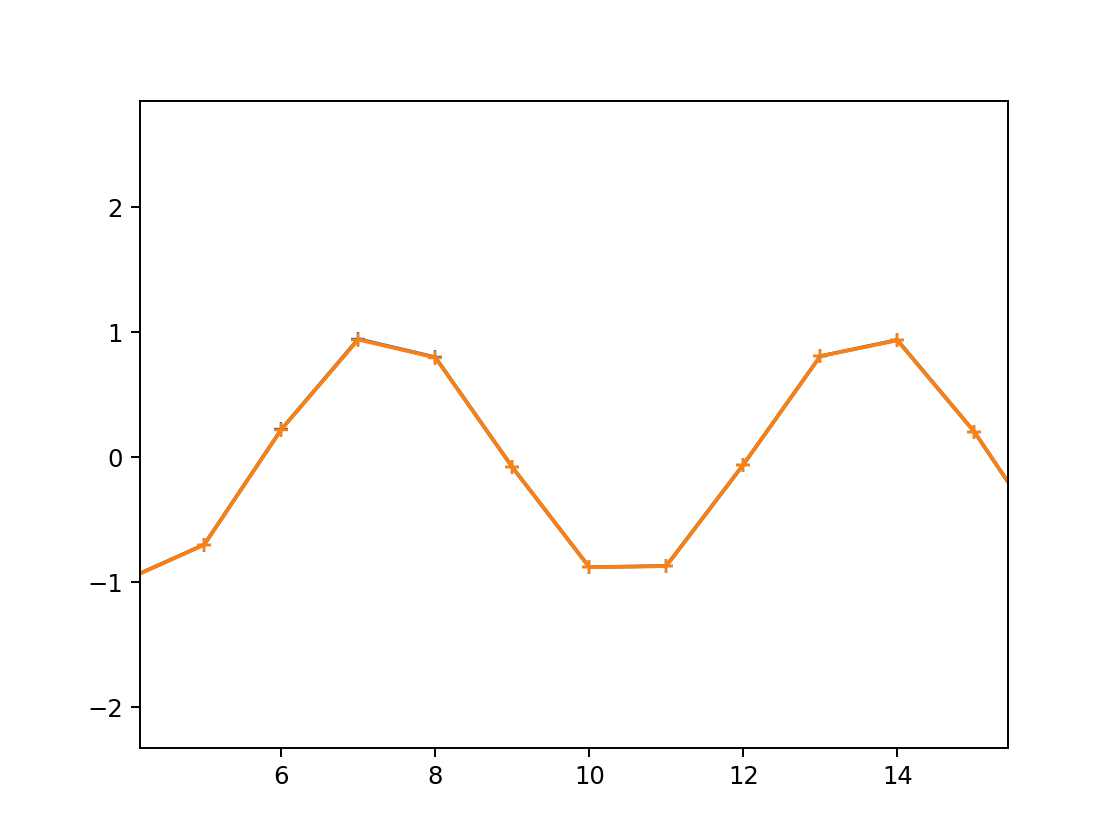

In [126]:
plt.figure()
plt.plot(y_pred.flatten(), marker='+')
plt.plot(Y_test.flatten(), marker='+')
plt.show()

In [98]:
y_pred

array([[[ 188.94189453],
        [ 189.74819946],
        [ 190.7144165 ],
        [ 191.7243042 ],
        [ 192.72593689],
        [ 193.66757202],
        [ 194.6859436 ],
        [ 195.72480774],
        [ 196.72779846],
        [ 197.71795654],
        [ 198.70747375],
        [ 199.66674805],
        [ 200.74726868],
        [ 201.68795776],
        [ 202.68127441],
        [ 203.67219543],
        [ 204.68920898],
        [ 205.67245483],
        [ 206.67486572],
        [ 207.67630005]]], dtype=float32)

In [127]:
# comme on a un processus aleatoire.. c'est tres difficile de prevoir la valeur suivante..
# si on test avec un sinus.. ça devrait etre plus simple
# quite easy avec un sinus..

# cool.. bon c'est tout pour ce soir